# Deep Deinterlacer

Будем реализовывать статью https://arxiv.org/abs/1708.00187

## 0. Download Data

#### Full Dataset [5.3 GB]

In [0]:
# !wget https://titan.gml-team.ru://courses/2019-spring/deint/data.zip

In [0]:
# !unzip data.zip

#### Tiny Dataset [0.5 GB]

In [1]:
# !wget https://titan.gml-team.ru://courses/2019-spring/deint/tiny_data.zip

--2020-03-18 11:41:53--  https://titan.gml-team.ru//courses/2019-spring/deint/tiny_data.zip
Resolving titan.gml-team.ru (titan.gml-team.ru)... 188.44.41.88
Connecting to titan.gml-team.ru (titan.gml-team.ru)|188.44.41.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494869128 (472M) [application/zip]
Saving to: ‘tiny_data.zip’

tiny_data.zip       100%[===================>] 471.94M  7.51MB/s    in 68s     

2020-03-18 11:43:03 (6.94 MB/s) - ‘tiny_data.zip’ saved [494869128/494869128]



In [0]:
# !unzip tiny_data.zip

In [0]:
from PIL import Image

img = Image.open('tiny_data/trn/0/00000.png')
img.size

## 1. Import TensorFlow

In [0]:
# For local use you should install TensorFlow for CPU or GPU
# !pip install tensorflow==2.1
# !pip install tensorflow-gpu==2.1

In [2]:
!nvidia-smi

Wed Mar 18 11:47:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow.keras as keras

import numpy as np
import matplotlib.pyplot as plt

import skimage
import skimage.io
import skimage.transform

import os

TensorFlow 2.x selected.


In [4]:
tf.__version__

'2.1.0'

## 2. Data Preparation

In [0]:
def read_and_maybe_resize_image(image_path, target_size=None, normalize=True):
    image = skimage.io.imread(image_path).astype('float32')
    if normalize:
        image /= 255.
    
    # Resize only if needed.
    if (target_size is not None and
        (image.shape[0] != target_size[0] or
         image.shape[1] != target_size[1])):
        image = skimage.transform.resize(image, target_size)
        
    return image


def read_consequent_frames(frames_dir, target_size=None):
    frame_file_names = sorted(os.listdir(frames_dir))
    return [
        read_and_maybe_resize_image(
            image_path=os.path.join(frames_dir, file_name),
            target_size=target_size,
            normalize=True
        )
        for file_name in frame_file_names
    ]
  
  
def extract_patches(image, patch_size):
    image_height, image_width = image.shape[:2]
    patch_height, patch_width = patch_size
    patch_shape = (patch_height, patch_width, 3)
      
    # Crop image.
    height = image_height - image_height % patch_height
    width = image_width - image_width % patch_width

    # Extract patches of desired size.
    patches = skimage.util.view_as_blocks(
        image[:height, :width], patch_shape
    ).reshape((-1, *patch_shape))

    return patches

Самый простой случай:

$X_k = \langle I_{n}^{odd}, I_{n+1}^{even} \rangle$

$y_k = \langle I_{n}^{even}, I_{n+1}^{odd} \rangle$

In [0]:
def get_train_sample(consequent_frames, patch_size):
    first_frame, second_frame = consequent_frames[:2]
    assert first_frame.shape == second_frame.shape

    first_patches = extract_patches(first_frame, patch_size)
    second_patches = extract_patches(second_frame, patch_size)

    X = np.zeros_like(first_patches)
    X[:, ::2] = first_patches[:, ::2]
    X[:, 1::2] = second_patches[:, 1::2]

    y = (first_patches[:, 1::2], second_patches[:, ::2])

    return X, y

In [0]:
def read_data(folder, frame_size, patch_size):
    X = []
    y = [[], []]

    for subfolder in os.listdir(folder):
        frames_dir = os.path.join(folder, subfolder)
        if not os.path.isdir(frames_dir):
            continue
            
        frames = read_consequent_frames(frames_dir, frame_size)
        Xs, ys = get_train_sample(frames, patch_size)
        
        X.append(Xs)
        y[0].append(ys[0])
        y[1].append(ys[1])
        
    X = np.concatenate(X)
    
    y[0] = np.concatenate(y[0])
    y[1] = np.concatenate(y[1])    
        
    return X, y

In [0]:
X_trn, y_trn = read_data(
    'tiny_data/trn',
    frame_size=(540, 960),
    patch_size=(64, 64)
)

X_vld, y_vld = read_data(
    'tiny_data/vld',
    frame_size=(540, 960),
    patch_size=(64, 64)
)

In [11]:
X_trn.shape

(1320, 64, 64, 3)

In [12]:
y_trn[0].shape, y_trn[1].shape

((1320, 32, 64, 3), (1320, 32, 64, 3))

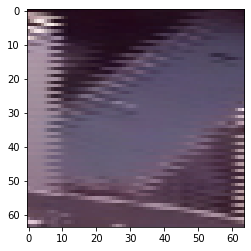

In [13]:
plt.imshow(X_trn[100])

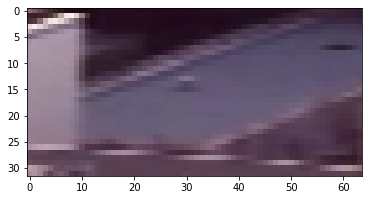

In [14]:
plt.imshow(y_trn[0][100])

## 3.Data Generator
What if you don't have enough RAM to store all the data?


In [0]:
# Code for tensorflow 2.x will be added soon

In [0]:
# For TensorFlow 1.x:

class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataset_dir, patch_size, frame_size):
        self.dataset_dir = dataset_dir
        self.patch_size = patch_size
        self.frame_size = frame_size
        
        self.batch_size = (
            (self.frame_size[0] // self.patch_size[0]) *
            (self.frame_size[1] // self.patch_size[1])
        )
        
        self._sequence_names = [
            d for d in os.listdir(dataset_dir)
            if not d.startswith('.')
        ]

    def __len__(self):
        return len(self._sequence_names)

    def __getitem__(self, idx):
        frames_dir = os.path.join(self.dataset_dir, self._sequence_names[idx])
        frames = read_consequent_frames(frames_dir, self.frame_size)
        X, y = get_train_sample(frames, self.patch_size)
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self._sequence_names)

In [0]:
trn_gen = DataGenerator('tiny_data/trn', frame_size=(1080, 1920), patch_size=(64, 64))
vld_gen = DataGenerator('tiny_data/vld', frame_size=(1080, 1920), patch_size=(64, 64))

## 4. Building Model

Keras functional API: https://keras.io/getting-started/functional-api-guide/

In [0]:
def build_model(input_shape=(None, None, 3)):
    # Input tensor — patch of `input_shape`
    inputs = keras.layers.Input(shape=input_shape, name='input')

    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',  # relu(x) = max(0, x)
    )(inputs)
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
    )(x)
    x = keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        activation='relu',
    )(x)

    current_even = keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(2, 1),
        padding='same',
        activation='relu',
    )(x)
    current_even = keras.layers.Conv2D(
        filters=3,
        kernel_size=(3, 3),
        padding='same',
        activation='sigmoid',
        name='current_even',
    )(current_even)

    next_odd = keras.layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(2, 1),
        padding='same',
        activation='relu',
    )(x)
    next_odd = keras.layers.Conv2D(
        filters=3,
        kernel_size=(3, 3),
        padding='same',
        activation='sigmoid',
        name='next_odd',
    )(next_odd)

    # This creates a model.
    model = keras.models.Model(
        inputs=inputs,
        outputs=[current_even, next_odd]
    )

    return model

## 5. Training

__Пайплайн обучения__:
* Определить __таргет__. В нашей задаче это недостающие строки двух последовательных кадров
* Определить __функцию потерь (loss)__. У нас всё просто: хочется, чтобы изображения мало отличались друг от друга, поэтому используем MSE между таргетом и предсказанием сети.
* Выбрать __оптимизатор__. Задача не из простых, но если хочется, чтобы всё быстро полетело, то лучше всего `Adam`.

Шпаргалка по отпимизаторам: https://habr.com/ru/post/318970/

In [0]:
model = build_model()

model.compile(
    optimizer='adam',
    loss={
        'current_even': 'mse',
        'next_odd': 'mse',
    }
)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 18464       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
# history = model.fit_generator(
#     generator=trn_gen,
#     steps_per_epoch=len(trn_gen),
#     epochs=1,
#     verbose=1,
#     validation_data=vld_gen,
#     validation_steps=len(vld_gen),
#     use_multiprocessing=True,
#     workers=16,
#     max_queue_size=32
# )

In [19]:
history = model.fit(X_trn, y_trn, epochs=5, validation_data=(X_vld, y_vld))

Train on 1320 samples, validate on 360 samples
Epoch 1/5
1320/1320 [==============================] - 5s 4ms/sample - loss: 0.0852 - current_even_loss: 0.0403 - next_odd_loss: 0.0438 - val_loss: 0.0206 - val_current_even_loss: 0.0098 - val_next_odd_loss: 0.0097
Epoch 2/5
1320/1320 [==============================] - 2s 2ms/sample - loss: 0.0135 - current_even_loss: 0.0068 - next_odd_loss: 0.0066 - val_loss: 0.0082 - val_current_even_loss: 0.0040 - val_next_odd_loss: 0.0039
Epoch 3/5
1320/1320 [==============================] - 2s 2ms/sample - loss: 0.0072 - current_even_loss: 0.0036 - next_odd_loss: 0.0036 - val_loss: 0.0060 - val_current_even_loss: 0.0029 - val_next_odd_loss: 0.0029
Epoch 4/5
1320/1320 [==============================] - 2s 2ms/sample - loss: 0.0055 - current_even_loss: 0.0027 - next_odd_loss: 0.0028 - val_loss: 0.0045 - val_current_even_loss: 0.0021 - val_next_odd_loss: 0.0022
Epoch 5/5
1320/1320 [==============================] - 2s 2ms/sample - loss: 0.0041 - current

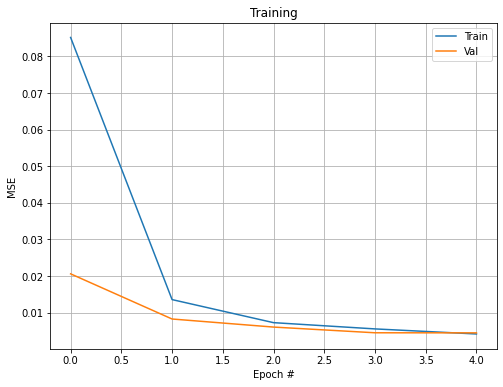

In [20]:
_, ax = plt.subplots(figsize=(8, 6))

ax.plot(history.history['loss'], label='Train')
ax.plot(history.history['val_loss'], label='Val')

ax.set_xlabel('Epoch #')
ax.set_ylabel('MSE')
ax.set_title('Training')

ax.legend()
ax.grid()

plt.show()

## 6. Evaluation

In [0]:
def evaluate(model, interlaced_image):
    current_even, next_odd = model.predict(interlaced_image[np.newaxis, ...])

    first = np.zeros_like(interlaced_image)
    first[::2] = interlaced_image[::2]
    first[1::2] = current_even[0]
    
    second = np.zeros_like(interlaced_image)
    second[1::2] = interlaced_image[1::2]
    second[::2] = next_odd[0]
    
    return first, second

In [0]:
test_image = read_and_maybe_resize_image('tiny_data/test/interlace/0/00000.png')

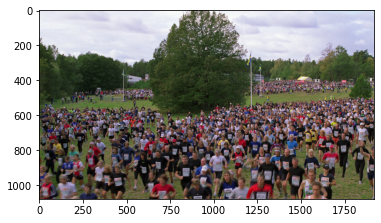

In [23]:
plt.imshow(test_image)

In [0]:
first, second = evaluate(model, test_image)

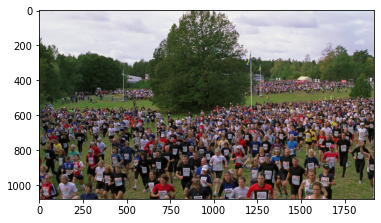

In [25]:
plt.imshow(first)

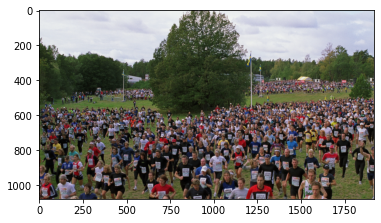

In [26]:
plt.imshow(second)

In [0]:
gt_image = read_and_maybe_resize_image('tiny_data/test/gt/0/00000.png')

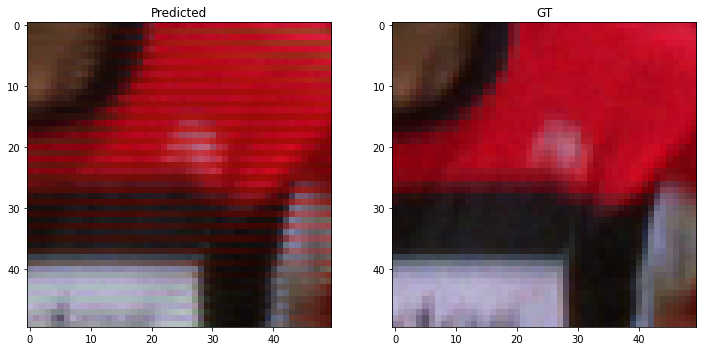

In [28]:
_, axs = plt.subplots(ncols=2, figsize=(12, 6))

hor = slice(1000, 1050)
ver = slice(1275, 1325)

axs[0].imshow(first[hor, ver])
axs[0].set_title('Predicted')

axs[1].imshow(gt_image[hor, ver])
axs[1].set_title('GT')

plt.show()

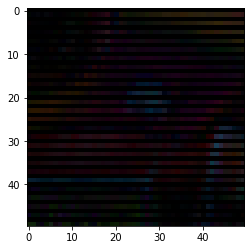

In [29]:
plt.imshow(np.abs(first[hor, ver] - gt_image[hor, ver]))

In [30]:
np.abs(first[hor, ver] - gt_image[hor, ver]).max()

0.35734445

## 7. Save/Load Model

In [0]:
model.save('my_best_model.h5')

In [0]:
new_model = keras.models.load_model('my_best_model.h5')

In [32]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, None, 3 18464       conv2d_1[0][0]                   
______________________________________________________________________________________________